<a href="https://colab.research.google.com/github/Nayoung-young/prj-ecommerce-ltv/blob/main/e_commerce_LTV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# _0.라이브러리 임포트

In [1]:
!pip install plotly
!pip install Lifetimes
!pip install nb_black

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import pandas as pd # python에서의 엑셀과 같은 역할
import numpy as np # 계산을 편하게 해 주는 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt # 시각화
import seaborn as sns # 시각화
import math

import matplotlib.ticker as ticker # 시각화
import matplotlib.dates as mdates # 시각화

import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='white')

# from other 
import matplotlib.colors as mcolors
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
%matplotlib inline
sns.set_style('whitegrid')
palette = 'Set2'

# sns.set(font_scale=2)

# _1. 데이터 불러오기 

In [5]:
%%time
df = pd.read_csv('/content/e-commerce_LTV.csv', encoding= 'unicode_escape')
df_base = df.copy()

CPU times: user 185 ms, sys: 45.8 ms, total: 231 ms
Wall time: 283 ms


In [6]:
df_base.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75106 entries, 0 to 75105
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    75106 non-null  object 
 1   StockCode    75106 non-null  object 
 2   Description  74903 non-null  object 
 3   Quantity     75105 non-null  float64
 4   InvoiceDate  75105 non-null  object 
 5   UnitPrice    75105 non-null  float64
 6   CustomerID   46828 non-null  float64
 7   Country      75105 non-null  object 
dtypes: float64(3), object(5)
memory usage: 4.6+ MB


In [8]:
len(df_base['InvoiceNo'].unique().tolist()) # InvoiceNo가 primary key인가? -> Nope 

3339

In [9]:
print(min(df_base['Quantity'].tolist()))
print(max(df_base['Quantity'].tolist())) # Quantity 범위 확인 

-74215.0
74215.0


In [10]:
quantity = df_base['Quantity'].tolist() 

print(len(list(filter(lambda x: x < 0, quantity)))) # quantity < 0 인 경우 
print(len(list(filter(lambda x: x > 0, quantity)))) # quantity > 0 인 경우 

1511
73594


In [11]:
sum(df_base['Quantity'].dropna())

633747.0

In [12]:
df_base['Country'].unique().tolist() # Country 고유값

['United Kingdom',
 'France',
 'Australia',
 'Netherlands',
 'Germany',
 'Norway',
 'EIRE',
 'Switzerland',
 'Spain',
 'Poland',
 'Portugal',
 'Italy',
 'Belgium',
 'Lithuania',
 'Japan',
 'Iceland',
 'Channel Islands',
 'Denmark',
 'Cyprus',
 'Sweden',
 'Austria',
 'Israel',
 'Finland',
 'Bahrain',
 'Greece',
 'Hong Kong',
 'Singapore',
 'Lebanon',
 nan]

In [13]:
# df_base.groupby(['Country']).agg(country_cnt = ('Country', 'count')).reset_index().sort_values(by = 'country_cnt', ascending =False)

#_1. 데이터 전처리

In [14]:
df_base.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

## 1.1 컬럼명 바꾸기 

In [15]:
# 컬럼 이름 snake case 로 rename 
%%time
df_base.rename(columns = {'InvoiceNo':'invoice_no', 
                        'StockCode':'stock_code', 
                        'Quantity': 'quantity',
                        'Description':'description',
                        'InvoiceDate': 'invoice_date',
                        'UnitPrice': 'unit_price', 
                        'CustomerID': 'customer_id', 
                        'Country':'country'}, inplace = True)

CPU times: user 1.84 ms, sys: 0 ns, total: 1.84 ms
Wall time: 13.4 ms


In [16]:
LTV_columns = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'customer_id']
df_LTV = df_base[LTV_columns]

In [17]:
df_LTV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75106 entries, 0 to 75105
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   invoice_no    75106 non-null  object 
 1   stock_code    75106 non-null  object 
 2   quantity      75105 non-null  float64
 3   invoice_date  75105 non-null  object 
 4   unit_price    75105 non-null  float64
 5   customer_id   46828 non-null  float64
dtypes: float64(3), object(3)
memory usage: 3.4+ MB


## 1.2 결측값 처리 
- customer_id: 
  - 결측값 = 비회원으로 추정
  - 추후 LTV 계산에서 활용하지는 않을 것이지만 fillna(0)
  - object로 타입 변환 

In [18]:
df_LTV_01 = df_LTV.copy()

In [19]:
## customer_id type 변환해도될지 체크 
%%time 
list(filter(lambda x: str(x)[-1] != '0', df_LTV_01['customer_id'].unique().tolist()))

CPU times: user 2.34 ms, sys: 2.93 ms, total: 5.27 ms
Wall time: 11.6 ms


[nan]

In [20]:
df_LTV_01['customer_id'].isna().sum() # customer_id 결측값 확인 

28278

In [21]:
df_LTV_01.sample(5)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
25665,538379,21375,3.0,12/12/2010 11:26,5.45,17126.0
19707,537886,84945,24.0,12/9/2010 9:49,0.85,15660.0
71833,542215,22242,12.0,1/26/2011 12:27,1.65,12472.0
38500,539579,22666,1.0,12/20/2010 12:51,2.95,16713.0
49778,540531,84836,2.0,1/9/2011 14:03,1.25,16549.0


In [22]:
df_LTV_01[df_LTV_01['invoice_no'] == '536865' ] # 비회원으로 추정, LTV 계산에서 활용 불가 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
5546,536865,10002,5.0,12/3/2010 11:28,1.66,NaN
5547,536865,15056bl,2.0,12/3/2010 11:28,12.72,NaN
5548,536865,18098c,7.0,12/3/2010 11:28,5.06,NaN
5549,536865,20615,1.0,12/3/2010 11:28,4.21,NaN
5550,536865,20655,1.0,12/3/2010 11:28,2.51,NaN
...,...,...,...,...,...,...
5681,536865,85099B,1.0,12/3/2010 11:28,4.21,NaN
5682,536865,85152,1.0,12/3/2010 11:28,4.21,NaN
5683,536865,85176,1.0,12/3/2010 11:28,1.66,NaN
5684,536865,M,1.0,12/3/2010 11:28,2.55,NaN


In [23]:
df_LTV_01['customer_id'] = df_LTV_01['customer_id'].fillna(0)

In [24]:
df_LTV_01['customer_id'].isna().sum() # customer_id

0

In [93]:
%%time 
df_LTV_01 = df_LTV_01.astype({'customer_id' : 'int'}) # float 였으므로 .0 없애기 위해 먼저 int로 변환 
df_LTV_01 = df_LTV_01.astype({'customer_id' : 'str'})

CPU times: user 43.8 ms, sys: 6.09 ms, total: 49.9 ms
Wall time: 50.5 ms


In [95]:
## invoice_no, stock_code도 type str로 변경 
df_LTV_01 = df_LTV_01.astype({'invoice_no' : 'str'})
df_LTV_01 = df_LTV_01.astype({'stock_code' : 'str'})

In [96]:
df_LTV_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75106 entries, 0 to 75105
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   invoice_no     75106 non-null  object        
 1   stock_code     75106 non-null  object        
 2   quantity       75105 non-null  float64       
 3   invoice_date   75105 non-null  datetime64[ns]
 4   unit_price     75105 non-null  float64       
 5   customer_id    75106 non-null  object        
 6   invoice_year   75105 non-null  float64       
 7   invoice_month  75105 non-null  float64       
 8   invoice_day    75105 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 5.2+ MB


## 1.3 invoice_date
- 현재 type: object -> datetime으로 변경 

In [27]:
df_LTV_01.sample(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
62401,541497,22280,5.0,1/18/2011 15:19,0.83,0
40754,539741,22653,1.0,12/21/2010 15:20,4.21,0
68173,541855,85053,2.0,1/23/2011 14:59,2.10,13742
15338,537638,22461,1.0,12/7/2010 15:28,25.49,0
3180,536607,21955,2.0,12/2/2010 9:29,7.95,17732
67672,541843,71101E,12.0,1/23/2011 12:08,0.85,13659
50502,540551,22587,4.0,1/10/2011 9:43,1.66,0
41906,539958,21870,2.0,12/23/2010 13:26,3.36,0
47752,540418,20653,2.0,1/7/2011 11:04,0.85,0
71309,542115,22430,1.0,1/25/2011 14:01,9.96,0


In [28]:
df_LTV_01['invoice_date'] = pd.to_datetime(df_LTV_01['invoice_date'], format = '%m/%d/%Y %H:%M')

In [29]:
df_LTV_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75106 entries, 0 to 75105
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    75106 non-null  object        
 1   stock_code    75106 non-null  object        
 2   quantity      75105 non-null  float64       
 3   invoice_date  75105 non-null  datetime64[ns]
 4   unit_price    75105 non-null  float64       
 5   customer_id   75106 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 3.4+ MB


In [30]:
# date관련 데이터 추가하기: 월 정보
df_LTV_01['invoice_year'] = df_LTV_01['invoice_date'].dt.year
df_LTV_01['invoice_month'] = df_LTV_01['invoice_date'].dt.month
df_LTV_01['invoice_day'] = df_LTV_01['invoice_date'].dt.day

df_LTV_01 = df_LTV_01.astype({'invoice_year' : 'int'}) 
df_LTV_01 = df_LTV_01.astype({'invoice_month' : 'int'}) 
df_LTV_01 = df_LTV_01.astype({'invoice_day' : 'int'}) 

df_LTV_01.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day
0,536365,85123A,6.0,2010-12-01 08:26:00,2.55,17850,2010.0,12.0,1.0
1,536365,71053,6.0,2010-12-01 08:26:00,3.39,17850,2010.0,12.0,1.0
2,536365,84406B,8.0,2010-12-01 08:26:00,2.75,17850,2010.0,12.0,1.0
3,536365,84029G,6.0,2010-12-01 08:26:00,3.39,17850,2010.0,12.0,1.0
4,536365,84029E,6.0,2010-12-01 08:26:00,3.39,17850,2010.0,12.0,1.0


#_2. 파악을 위한 시각화 

**[ 변수 정보 ]**
*   InvoiceNo: Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
*   StockCode: Product code that consists 5 digits.
*   Description: Product name.
*   Quantity: The quantities of each product per transaction.
*   InvoiceDate: Represents the day and time when each transaction was generated.
*   CustomerID: Customer number that consists 5 digits. Each customer has a unique customer ID.
*   Country: Name of the country where each customer resides.


In [31]:
# 시각화 라이브러리 
import plotly.graph_objs as go
from plotly.offline import iplot

In [32]:
world_map = df_base[['customer_id', 'invoice_no', 'country']
              ].groupby(['customer_id', 'invoice_no', 'country']
                       ).count().reset_index()

countries = world_map['country'].value_counts()

data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Viridis',
            reversescale = False)

layout = dict(title={'text': "Number of Orders by Countries",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

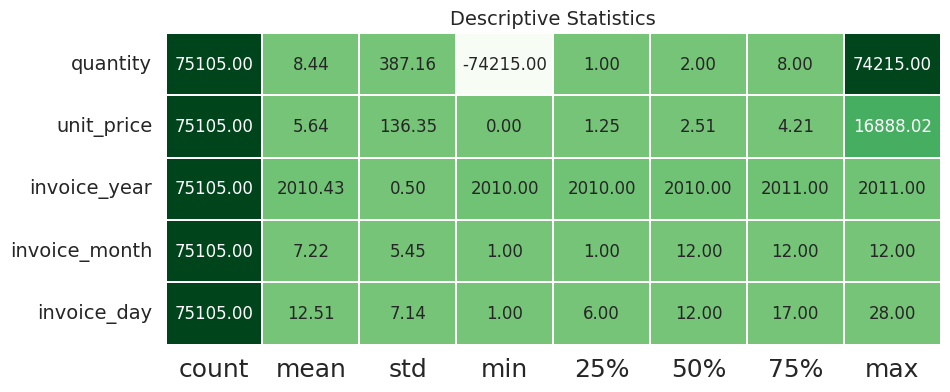

In [33]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= dataframe.describe().T.columns,
                           data= dataframe.describe().T)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0] * 0.81))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Greens",
                fmt = '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.1,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(df_LTV_01.select_dtypes(include = [float, int]))

* 취소된 주문내역 때문에 quantity < 0인 row 존재 
* total_price = quantity * unit_price로 구할 예정 

## 2.1 unit_price, quantity에 대한 확인 
- quantity < 0 인 부분 확인  
- stock_code가 같은데도 unit_price가 다른 경우에 대한 확인 

In [34]:
df_LTV_01[df_LTV_01['quantity'] < 0].sample(5)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day
39442,C539644,21232,-4.0,2010-12-20 15:52:00,1.25,12471,2010.0,12.0,20.0
37738,C539476,22138,-1.0,2010-12-19 14:43:00,4.95,16686,2010.0,12.0,19.0
45954,C540346,22077,-4.0,2011-01-06 13:41:00,1.65,12471,2011.0,1.0,6.0
68355,C541863,85099B,-6.0,2011-01-23 16:08:00,1.65,13798,2011.0,1.0,23.0
70398,C542038,22727,-1.0,2011-01-25 11:47:00,3.75,14534,2011.0,1.0,25.0


In [52]:
pd.set_option('display.max_columns', None) ## 모든 열을 출력한다.
pd.set_option('display.max_rows', None) ## 모든 열을 출력한다.

In [54]:
df_LTV_01[df_LTV_01['customer_id'] == 12471] # quantity < 0인 행이 있는 customer 확인 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day
3338,C536622,22752,-2.0,2010-12-02 10:37:00,8.50,12471,2010.0,12.0,2.0
22535,538174,21210,12.0,2010-12-10 09:35:00,1.45,12471,2010.0,12.0,10.0
22536,538174,21212,24.0,2010-12-10 09:35:00,0.55,12471,2010.0,12.0,10.0
22537,538174,21578,24.0,2010-12-10 09:35:00,2.25,12471,2010.0,12.0,10.0
22538,538174,21700,72.0,2010-12-10 09:35:00,0.85,12471,2010.0,12.0,10.0
22539,538174,16235,60.0,2010-12-10 09:35:00,0.21,12471,2010.0,12.0,10.0
22540,538174,21731,48.0,2010-12-10 09:35:00,1.65,12471,2010.0,12.0,10.0
22541,538174,21787,24.0,2010-12-10 09:35:00,0.85,12471,2010.0,12.0,10.0
22542,538174,21232,36.0,2010-12-10 09:35:00,1.25,12471,2010.0,12.0,10.0
22543,538174,22077,24.0,2010-12-10 09:35:00,1.65,12471,2010.0,12.0,10.0


In [55]:
# 539644	
df_LTV_01[df_LTV_01['invoice_no'] == 539644] 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day


- invoice_no 가장 앞에 C가 있으면 취소한 내역, 취소했을 시 quantity < 0 
- but, C 뒤 번호로 어떤 내역을 취소한 건지 확인 불가 (해당하는 invoice_no 없음) 

우리는 구매 내역만 필요한 거니까 그냥 무시하고 total_price 계산해도 될 듯?? 
quantity < 0 인 경우를 확인해보자. 

In [57]:
df_LTV_01[df_LTV_01['unit_price'] < 0]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day


In [35]:
df_LTV_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75106 entries, 0 to 75105
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   invoice_no     75106 non-null  object        
 1   stock_code     75106 non-null  object        
 2   quantity       75105 non-null  float64       
 3   invoice_date   75105 non-null  datetime64[ns]
 4   unit_price     75105 non-null  float64       
 5   customer_id    75106 non-null  object        
 6   invoice_year   75105 non-null  float64       
 7   invoice_month  75105 non-null  float64       
 8   invoice_day    75105 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 5.2+ MB


In [36]:
df_LTV_01[df_LTV_01['unit_price'] < 0] # unit_price < 0 인 경우는 없음 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day


In [66]:
df_LTV_01[df_LTV_01['unit_price'] == 0].sample(5) # unit_price == 0인 경우 확인 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day
12008,537361,21777,5.0,2010-12-06 12:34:00,0.0,0,2010.0,12.0,6.0
74288,542418,84966A,-17.0,2011-01-27 17:39:00,0.0,0,2011.0,1.0,27.0
74839,542532,DCGS0074,-1.0,2011-01-28 13:09:00,0.0,0,2011.0,1.0,28.0
7209,537017,47556B,-69.0,2010-12-03 15:41:00,0.0,0,2010.0,12.0,3.0
41486,539856,22475,5.0,2010-12-22 14:41:00,0.0,0,2010.0,12.0,22.0


In [72]:
print((df_LTV_01[df_LTV_01['unit_price'] == 0].shape)) 
print((df_LTV_01[df_LTV_01['customer_id'] == 0].shape))

print((df_LTV_01[(df_LTV_01['customer_id'] == 0) & (df_LTV_01['unit_price'] == 0)].shape))

(377, 9)
(28278, 9)
(371, 9)


In [74]:
df_LTV_01[ (df_LTV_01['unit_price'] == 0) & (df_LTV_01['customer_id'] != 0) ]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day
9302,537197,22841,1.0,2010-12-05 14:02:00,0.0,12647,2010.0,12.0,5.0
33576,539263,22580,4.0,2010-12-16 14:36:00,0.0,16560,2010.0,12.0,16.0
40089,539722,22423,10.0,2010-12-21 13:45:00,0.0,14911,2010.0,12.0,21.0
47068,540372,22090,24.0,2011-01-06 16:41:00,0.0,13081,2011.0,1.0,6.0
47070,540372,22553,24.0,2011-01-06 16:41:00,0.0,13081,2011.0,1.0,6.0
56674,541109,22168,1.0,2011-01-13 15:10:00,0.0,15107,2011.0,1.0,13.0


In [76]:
df_base[df_base['stock_code'] == '22841'] # unit_price == 0 이고 customer_id != 0 인 상품의 description 확인 

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
2834,536592,22841,ROUND CAKE TIN VINTAGE GREEN,1.0,12/1/2010 17:06,16.13,NaN,United Kingdom
3925,536738,22841,ROUND CAKE TIN VINTAGE GREEN,2.0,12/2/2010 13:06,7.95,15827.0,United Kingdom
5111,536844,22841,ROUND CAKE TIN VINTAGE GREEN,2.0,12/2/2010 18:49,7.95,14236.0,United Kingdom
5328,536859,22841,ROUND CAKE TIN VINTAGE GREEN,1.0,12/3/2010 10:43,7.95,12841.0,United Kingdom
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1.0,12/5/2010 14:02,0.00,12647.0,Germany
9543,537207,22841,ROUND CAKE TIN VINTAGE GREEN,1.0,12/5/2010 15:06,7.95,17402.0,United Kingdom
9837,537219,22841,ROUND CAKE TIN VINTAGE GREEN,1.0,12/5/2010 15:47,7.95,14081.0,United Kingdom
10632,537237,22841,ROUND CAKE TIN VINTAGE GREEN,1.0,12/6/2010 9:58,16.13,NaN,United Kingdom
16285,537646,22841,ROUND CAKE TIN VINTAGE GREEN,1.0,12/7/2010 15:39,7.95,17591.0,United Kingdom
18090,537794,22841,ROUND CAKE TIN VINTAGE GREEN,1.0,12/8/2010 13:01,7.95,16713.0,United Kingdom


In [64]:
df_base[df_base['stock_code'] == '22034'] # unit_price == 0 인 상품 확인 

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
8828,537153,22034,ROBIN CHRISTMAS CARD,3.0,12/5/2010 13:03,0.42,16718.0,United Kingdom
19996,537999,22034,NaN,-223.0,12/9/2010 11:44,0.00,NaN,United Kingdom
35347,539436,22034,ROBIN CHRISTMAS CARD,5.0,12/17/2010 14:49,0.42,NaN,United Kingdom
44297,C540164,22034,ROBIN CHRISTMAS CARD,-12.0,1/5/2011 12:02,0.42,14911.0,EIRE


- unit_price = 0인 이유에 대해 확정짓기 어려움 

    - 같은 stock_code인데도 unit_price = 0 인 경우 존재 
    -  unit_price = 0 인 경우 중 customer_id이 NaN이었던 경우가 대부분이긴 했으나, 이유를 추측하기 어려움 


**추측**
1.   단기성 이벤트로 해당 상품을 무료로 증정한 적이 있었다 
2.   프로모션이 진행됨에 따라 같은 stock_code여도 unit_price가 다를 수 있다 

어차피 unit_price = 0 인 경우에 대해서는 total_price = 0 이지만 구매 횟수에 영향을 줄 수 있으므로 남겨둔다. 
하지만 quantity < 0 인 경우는 구매가 아니므로 분리할 필요가 있음 

## 2.2 unit_price, quantity에 대한 추가 전처리 
- quantity < 0


In [84]:
## rollback을 위해 copy 
df_LTV_02 = df_LTV_01[df_LTV_01['quantity'] > 0]

In [85]:
## total_price = quantity * unit_price 열 추가 
df_LTV_02['total_price'] = df_LTV_02['quantity'] * df_LTV_02['unit_price']

In [86]:
df_LTV_01.shape

(75106, 9)

In [87]:
df_LTV_02.shape

(73594, 10)

In [ ]:
# df_LTV_02[ type(df_LTV_02['invoice_no']) == str && ]

#_3. Life Time Value (고객 생애가치) 계산 